# Instance Detection
Training:
1. Feature Extraction for instance profile images by DINOv2

Testing:
1. Mask Generation by SAM
2. Proposal Generation ('bbox' for keeping background and 'mask' for removing background)
2. Feature Extraction for proposals by DINOv2
3. Proposal/Instance Matching -- Rank & Select

In [1]:

from functools import partial
import argparse
import cv2
import glob
import json
import logging
import math
import os
import sys
import random
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
from PIL import Image, ImageFile

import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torchvision import transforms as pth_transforms

sys.path.append("../detectron2")
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.layers.nms import batched_nms
from detectron2.structures import Boxes, BoxMode, Instances

sys.path.append("../dinov2-main")
from dinov2.eval.setup import get_args_parser as get_setup_args_parser
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import extract_features

sys.path.append("../segment-anything")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sys.path.append(".")
from utils.data_utils import gen_square_crops
from utils.visualizer import ColorMode, Visualizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logger = logging.getLogger("dinov2")


class RealWorldDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, dataset, data=None, transform=None, imsize=None):

        

        if dataset == 'Object':

            num_obj = []
            image_dir = []
            mask_dir = []
            count = []

            source_list = sorted(glob.glob(os.path.join(data_dir, '*')))

            for _, source_dir in enumerate(source_list):
                num_obj.append(source_dir.split('/')[-1].split('.')[0])
                image_paths = sorted([p for p in glob.glob(os.path.join(source_dir, 'images', '*'))
                                      if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
                image_dir.extend(image_paths)
                mask_paths = sorted([p for p in glob.glob(os.path.join(source_dir, 'masks', '*'))
                                     if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
                mask_dir.extend(mask_paths)
                count.append(len(image_paths))

            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = image_dir
            cfg['mask_dir'] = mask_dir
            cfg['obj_name'] = num_obj  # object lists for Object
            cfg['length'] = count

            self.samples = cfg['image_dir']

        elif dataset == 'Scene':

            num_scene = []
            image_dir = []
            proposals = []
            count = []

            with open(os.path.join(os.path.dirname(data_dir),
                                   'proposals_on_' + data_dir.split('/')[-1] + '.json')) as f:
                proposal_json = json.load(f)

            source_list = sorted(glob.glob(os.path.join(data_dir, '*')))

            for idx, source_dir in enumerate(source_list):
                scene_name = source_dir.split('/')[-1]
                num_scene.append(scene_name)

                image_paths = sorted([p for p in glob.glob(os.path.join(source_dir, '*'))
                                      if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
                image_dir.extend(image_paths)
                count.append(len(image_paths))
                proposals.extend(proposal_json[scene_name])

            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = image_dir
            cfg['proposals'] = proposals
            cfg['scene_name'] = num_scene  # scene list for Scene
            cfg['length'] = count

            self.samples = cfg['image_dir']

        else: # for demo scene image
            with open(os.path.join(data_dir, 'proposals_on_' + dataset + '.json')) as f:
                proposal_json = json.load(f)
                
            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = None
            cfg['proposals'] = proposal_json
            cfg['scene_name'] = [dataset]  # scene list for Scene
            cfg['length'] = [len(data)]

            self.samples = data


        self.cfg = cfg
        self.transform = transform
        self.imsize = imsize

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):


        if "test" in self.cfg['dataset']:
            img = self.samples[index]
        else:
            path = self.samples[index]
            ImageFile.LOAD_TRUNCATED_IMAGES = True
    
            with open(path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
                
        w, h = img.size        

        if (self.imsize is not None) and (min(w, h) > self.imsize):
            img.thumbnail((self.imsize, self.imsize), Image.ANTIALIAS)
        else:
            new_w = math.ceil(w / 14) * 14
            new_h = math.ceil(h / 14) * 14
            img = img.resize((new_w, new_h), Image.ANTIALIAS)



        if self.transform is not None:
            img = self.transform(img)
        return img, index


def compute_similarity(obj_feats, roi_feats):
    """
    Compute Cosine similarity between object features and proposal features
    """
    roi_feats = roi_feats.unsqueeze(-2)
    sim = torch.nn.functional.cosine_similarity(roi_feats, obj_feats, dim=-1)
    return sim


def get_args_parser(
        description: Optional[str] = None,
        parents: Optional[List[argparse.ArgumentParser]] = [],
        add_help: bool = True,
):
    setup_args_parser = get_setup_args_parser(parents=parents, add_help=False)
    parents = [setup_args_parser]

    parser = argparse.ArgumentParser(
        description=description,
        parents=parents,
        add_help=add_help,
    )
    parser.add_argument(
        "--train_path",
        default="../database/train",
        type=str,
        help="Path to train dataset.",
    )
    parser.add_argument(
        "--test_path",
        default="../database/test",
        type=str,
        help="Path to test dataset.",
    )
    parser.add_argument(
        "--imsize",
        default=224,
        type=int,
        help="Image size",
    )
    parser.add_argument(
        "--pretrained_weights",
        default="dinov2_vits14_pretrain.pth",
        type=str,
        help="Path to pretrained weights to evaluate.",
    )
    parser.add_argument(
        "--output_dir",
        default="./output",
        type=str,
        help="Path to save outputs.")
    parser.add_argument("--num_workers", default=0, type=int, help="Number of data loading workers per GPU.")

    parser.add_argument(
        "--gather-on-cpu",
        action="store_true",
        help="Whether to gather the train features on cpu, slower"
             "but useful to avoid OOM for large datasets (e.g. ImageNet22k).",
    )

    parser.set_defaults(
        train_dataset="Object",
        test_dataset="Scene",
        batch_size=1,
        num_workers=0,
    )
    return parser

In [2]:
# Default args and initialize model
args_parser = get_args_parser(description="SAM-DINOv2 Instance Detection")
imsize = 448
tag = "mask"  # bbox
args = args_parser.parse_args(args=["--config-file", "configs/vits14_pretrain.yaml",
                                    "--train_path", "../database/Objects",
                                    "--test_path", "test_data/test_1/test_002.jpg",
                                    "--pretrained_weights", "configs/dinov2_vits14_pretrain.pth",
                                    "--output_dir", "exps/output_RankSelect_" + str(imsize) + "_" + tag,
                                    ])
os.makedirs(args.output_dir, exist_ok=True)

model, autocast_dtype = setup_and_build_model(args)

I20230614 02:15:43 32878 dinov2 config.py:60] git:
  sha: N/A, status: clean, branch: N/A

I20230614 02:15:43 32878 dinov2 config.py:61] batch_size: 1
config_file: configs/vits14_pretrain.yaml
gather_on_cpu: False
imsize: 224
num_workers: 0
opts: ['train.output_dir=/home/SQQ/svid/demo-InsDet/exps/output_RankSelect_448_mask']
output_dir: /home/SQQ/svid/demo-InsDet/exps/output_RankSelect_448_mask
pretrained_weights: configs/dinov2_vits14_pretrain.pth
test_dataset: Scene
test_path: test_data/test_1/test_002.jpg
train_dataset: Object
train_path: ../database/Objects
I20230614 02:15:43 32878 dinov2 config.py:27] sqrt scaling learning rate; base: 0.004, new: 0.001
I20230614 02:15:43 32878 dinov2 config.py:34] MODEL:
  WEIGHTS: ''
compute_precision:
  grad_scaler: true
  teacher:
    backbone:
      sharding_strategy: SHARD_GRAD_OP
      mixed_precision:
        param_dtype: fp16
        reduce_dtype: fp16
        buffer_dtype: fp32
    dino_head:
      sharding_strategy: SHARD_GRAD_OP
      m

fatal: not a git repository (or any of the parent directories): .git


I20230614 02:15:43 32878 dinov2 utils.py:34] Pretrained weights found at configs/dinov2_vits14_pretrain.pth and loaded with msg: <All keys matched successfully>


### Traning (Feature Extraction on Object Instance Profile Images by DINOv2)

In [3]:
transform = pth_transforms.Compose([pth_transforms.ToTensor(),])
object_dataset = RealWorldDataset(args.train_path, args.train_dataset, transform=transform, imsize=args.imsize)

if os.path.exists(os.path.join(args.output_dir, 'object_features.json')):
    with open(os.path.join(args.output_dir, 'object_features.json'), 'r') as f:
        feat_dict = json.load(f)

    object_features = torch.Tensor(feat_dict['features']).cuda()

else:
    object_features, _ = extract_features(
        model, object_dataset, args.batch_size, args.num_workers
    )

    feat_dict = dict()
    feat_dict['features'] = object_features.detach().cpu().tolist()

    with open(os.path.join(args.output_dir, 'object_features.json'), 'w') as f:
        json.dump(feat_dict, f)

# normalize features
object_features = nn.functional.normalize(object_features, dim=1, p=2)

### Inference
#### 1. Instance Mask Generation by SAM

In [4]:
# read test image and resize to low-resolution
raw_image = cv2.cvtColor(cv2.imread(args.test_path), cv2.COLOR_BGR2RGB)
ratio = 0.25
scene_image = cv2.resize(raw_image, (int(raw_image.shape[1] * ratio), int(raw_image.shape[0] * ratio)), cv2.INTER_LINEAR)

# initialize sam
sam_checkpoint = "configs/sam_vit_l_0b3195.pth"
model_type = "vit_l"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(sam)

# generate masks
masks = mask_generator.generate(scene_image)

#### 2. Crop proposals from the high-resolution version

In [5]:
image_height, image_width = raw_image.shape[:-1]
scene_name = os.path.basename(args.test_path).split('.')[0]

sel_rois = []
rois = []
for ind, segment_dict in enumerate(masks):
    
    # bbox
    x0 = int(segment_dict['bbox'][0])
    y0 = int(segment_dict['bbox'][1])
    x1 = int(segment_dict['bbox'][0]) + int(segment_dict['bbox'][2])
    y1 = int(segment_dict['bbox'][1]) + int(segment_dict['bbox'][3])

    # scale up to adapt on raw image size
    if ratio != 0:
        x0 = int(x0 // ratio)
        y0 = int(y0 // ratio)
        x1 = int(x1 // ratio)
        y1 = int(y1 // ratio)

    # load mask
    mask = segment_dict['segmentation']

    # invert background to white
    new_image = Image.new('RGB', size=(image_width, image_height), color=(255, 255, 255))
    new_image.paste(Image.fromarray(raw_image), (0, 0), mask=Image.fromarray(mask).resize((image_width, image_height)))

    if tag == "mask":
        roi = gen_square_crops(new_image, [x0, y0, x1, y1]) # crop by mask
    elif tag == "bbox":
        roi = gen_square_crops(Image.fromarray(raw_image), [x0, y0, x1, y1]) # crop by bbox
    else:
        ValueError("Wrong tag!")
    
    rois.append(roi)
    
    # # save roi region
    # os.makedirs(os.path.join(args.output_dir, scene_name), exist_ok=True)
    # roi.save(os.path.join(args.output_dir, scene_name, scene_name + '_' + str(ind).zfill(3) + '.png'))

    # save bbox
    sel_roi = dict()
    sel_roi['roi_id'] = int(ind)
    sel_roi['image_id'] = int(scene_name.split('_')[-1])
    sel_roi['bbox'] = [segment_dict['bbox'][0], 
                       segment_dict['bbox'][1], 
                       segment_dict['bbox'][2], 
                       segment_dict['bbox'][3]]
    sel_roi['area'] = np.count_nonzero(mask)
    sel_roi['roi_dir'] = os.path.join(args.output_dir, scene_name, scene_name + '_' + str(ind).zfill(3) + '.png')
    sel_roi['image_dir'] = args.test_path
    sel_roi['image_width'] = scene_image.shape[1]
    sel_roi['image_height'] = scene_image.shape[0]
    sel_roi['scale'] = int(1/ratio)

    sel_rois.append(sel_roi)
    
with open(os.path.join(args.output_dir, 'proposals_on_' + scene_name + '.json'), 'w') as f:
    json.dump(sel_rois, f)


#### 4. Test Data Loader (Proposals) and Feature Extraction by DINOv2

In [6]:
transform = pth_transforms.Compose([pth_transforms.ToTensor(),])
# # for list of scene images
# scene_dataset = RealWorldDataset(args.test_path, args.test_dataset, transform=transform, imsize=args.imsize)
# for demo
scene_dataset = RealWorldDataset(args.output_dir, scene_name, data=rois, transform=transform, imsize=args.imsize)

if os.path.exists(os.path.join(args.output_dir, 'scene_features_' + scene_name + '.json')):
    with open(os.path.join(args.output_dir, 'scene_features_' + scene_name + '.json'), 'r') as f:
        feat_dict = json.load(f)

    scene_features = torch.Tensor(feat_dict['features']).cuda()

else:
    scene_features, _ = extract_features(
        model, scene_dataset, args.batch_size, args.num_workers
    )
    feat_dict = dict()
    feat_dict['features'] = scene_features.detach().cpu().tolist()

    with open(os.path.join(args.output_dir, 'scene_features_' + scene_name + '.json'), 'w') as f:
        json.dump(feat_dict, f)

# normalize features
scene_features = nn.functional.normalize(scene_features, dim=1, p=2)

####  4. Compute Cosine Similarity and Proposal/Instance Matching

In [7]:
# reshape scene feature matrix
scene_cnt = [0, *scene_dataset.cfg['length']]
scene_idx = [sum(scene_cnt[:i + 1]) for i in range(len(scene_cnt))]
scene_features_list = [scene_features[scene_idx[i]:scene_idx[i + 1]] for i in
                        range(len(scene_dataset.cfg['length']))]

proposals = scene_dataset.cfg['proposals']
proposals_list = [proposals[scene_idx[i]:scene_idx[i + 1]] for i in range(len(scene_dataset.cfg['length']))]

num_object = len(object_dataset.cfg['obj_name'])
num_example = len(object_features) // num_object

score_thresh_predefined = 0.5

results = []
    
for idx, scene_feature in enumerate(scene_features_list):
    sim_mat = compute_similarity(object_features, scene_feature)
    sim_mat = sim_mat.view(len(scene_feature), num_object, num_example)
    sims, _ = torch.max(sim_mat, dim=2)  # choose max score over profile examples of each object instance
    # sims[sims < score_thresh] = -1

    proposals = proposals_list[idx]

    # empirically make possible background with similarity score = -1
    bk_idx = []
    for j in range(len(proposals)):
        box_area = proposals[int(j)]['bbox'][-2] * proposals[int(j)]['bbox'][-1]
        if box_area > (1/256) * proposals[int(j)]['image_width'] * proposals[int(j)]['image_height'] :
            sims[j,:] = -1
        elif (proposals[int(j)]['area'] / box_area) < 0.5:
            sims[j,:] = -1

    ########################################## Rank and Select Strategy ##########################################
    # 1. rank row (rand objects for each proposal), 2. rank column (select best proposal-object match)
    obj_idx = list(np.arange(num_object))
    roi_idx = list(np.arange(len(scene_feature)))

    sim, rank = torch.max(sims, dim=-1)
    sel_obj = torch.unique(rank)
    sel_roi_list = [[x for x, y in list(enumerate(rank)) if y == u] for u in sel_obj]

    for k, ind in enumerate(sel_obj):
        sim_, seq = torch.sort(sim[sel_roi_list[k]], descending=True)
        if sim_[0] > score_thresh_predefined:
            sel_roi_idx = roi_idx[sel_roi_list[k][seq[0]]]
            sel_roi_sim = sim[sel_roi_list[k][seq[0]]]

            result = dict()
            result['image_id'] = proposals[sel_roi_idx]['image_id']
            result['category_id'] = int(ind)
            result['bbox'] = proposals[sel_roi_idx]['bbox']
            result['score'] = float(sel_roi_sim)
            result['image_width'] = proposals[sel_roi_idx]['image_width']
            result['image_height'] = proposals[sel_roi_idx]['image_height']
            result['scale'] = proposals[sel_roi_idx]['scale']
            results.append(result)

        else:
            continue

    # print("Done!")

### Save Results

In [8]:
# save final results
with open(os.path.join(args.output_dir, "coco_instances_results.json"), "w") as f:
    json.dump(results, f)

predictions = dict(
    [(k, {'image_id': -1, 'instances': []}) for k in range(len(scene_dataset.cfg['scene_name']))])
for idx in range(len(results)):
    id = results[idx]['image_id']
    predictions[scene_dataset.cfg['scene_name'].index('test_' + str(id).zfill(3))]['image_id'] = id

    predictions[scene_dataset.cfg['scene_name'].index('test_' + str(id).zfill(3))]['instances'].append(results[idx])

torch.save(predictions, os.path.join(args.output_dir, "instances_predictions.pth"))

print('Done!')

Done!


### Visualization

In [9]:
def show_anns(anns):
    """ref from segment-anything's notebook
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def getColor():
    color: int
    c1 = random.randint(16, 255)
    c2 = random.randint(16, 255)
    c3 = random.randint(16, 255)
    return (c1, c2, c3)


def create_instances(predictions, image_size, metadata):
    ret = Instances(image_size)

    score = np.asarray([x["score"] for x in predictions])
    chosen = (score > 0.5).nonzero()[0]
    score = score[chosen]
    bbox = np.asarray([predictions[i]["bbox"] for i in chosen]).reshape(-1, 4)
    bbox = BoxMode.convert(bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)

    labels = np.asarray([metadata.thing_dataset_id_to_contiguous_id[predictions[i]["category_id"]] for i in chosen])

    ret.scores = score
    ret.pred_boxes = Boxes(bbox)
    ret.pred_classes = labels

    try:
        ret.pred_masks = [predictions[i]["segmentation"] for i in chosen]
    except KeyError:
        pass
    return ret


def nms(pred_boxes, pred_scores, pred_classes):
    # Boxes
    boxes = pred_boxes.clone()
    # Scores
    scores = pred_scores.clone()
    # Classes
    classes = pred_classes.clone()

    # Perform nms
    iou_threshold = 0.5
    keep_id = batched_nms(boxes, scores, classes, iou_threshold)

    return keep_id


def apply_nms(pred):
    pred_boxes = pred.pred_boxes
    pred_scores = pred.scores
    pred_classes = pred.pred_classes
    iou_threshold = 0.5

    boxes_tmp = []
    scores_tmp = []
    classes_tmp = []

    for i, coordinates in enumerate(pred_boxes):
        boxes_tmp.append(coordinates.cpu().numpy())  # boxes_tmp.append(coordinates.cpu().numpy())
        scores_tmp.append(pred_scores[i])  # scores_tmp.append(pred_scores[idx].cpu())
        classes_tmp.append(pred_classes[i])  # classes_tmp.append(pred_classes[idx].cpu())

    boxes_tmp = torch.tensor(boxes_tmp)
    scores_tmp = torch.tensor(scores_tmp)
    classes_tmp = torch.tensor(classes_tmp)
    if len(boxes_tmp) != 0:
        keep_ids = batched_nms(boxes_tmp.cuda(), scores_tmp.cuda(), classes_tmp.cuda() * 0 + 1, iou_threshold)
    else:
        print("no box prediction!")
    return keep_ids

# Random custom colors with a fixed random seed
random.seed(77)
thing_colors = []
for i in range(100):
    thing_colors.append(getColor())

In [10]:
# Register Test Data for COCO evaluation
test_path = "./test_data/test_4" # 1 for raw data, 2 for ratio=0.5, 4 for ratio=0.25, 8 for ratio=0.125
test_json = "./test_data/annotations/instances_test_4.json"
register_coco_instances("coco_InsDet_test", {}, test_json, test_path)
MetadataCatalog.get("coco_realDB_test").thing_colors = thing_colors

In [11]:
pred_dir = os.path.join(args.output_dir,"predictions")
os.makedirs(pred_dir, exist_ok=True)
test_metadata = MetadataCatalog.get("coco_InsDet_test")
test_dataset_dicts = DatasetCatalog.get("coco_InsDet_test")

idx = scene_dataset.cfg['scene_name'].index(scene_name)
d = test_dataset_dicts[int(scene_name.split('_')[-1])]
img = cv2.imread(d["file_name"])
base_name = os.path.basename(d["file_name"]).split(".")[0]

# visualize GT
visGT = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1.0,
                   instance_mode=ColorMode.SEGMENTATION)
vis_gt = visGT.draw_dataset_dict(d)
cv2.imwrite(os.path.join(pred_dir, base_name + "_gt.jpg"),
            vis_gt.get_image()[:, :, ::-1])

# visualize pred
predictions = torch.load(os.path.join(args.output_dir, "instances_predictions.pth"))
pred = create_instances(predictions[idx]['instances'], img.shape[:2], test_metadata)
keep_ids = apply_nms(pred)  # apply NMS

visPred = Visualizer(img[:, :, ::-1],
                     metadata=test_metadata,
                     scale=1.0,
                     instance_mode=ColorMode.SEGMENTATION)
vis_pred = visPred.draw_instance_predictions(pred.to("cpu"), keep_ids)
cv2.imwrite(os.path.join(pred_dir, base_name + "_pred_SAM+DINOv2.jpg"),
            vis_pred.get_image()[:, :, ::-1])

E20230614 02:16:22 32878 iopath.common.file_io file_io.py:949] An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/dinov2/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/usr/local/anaconda3/envs/dinov2/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
I20230614 02:16:22 32878 detectron2.data.datasets.coco coco.py:145] Loaded 160 images in COCO format from ./test_data/annotations/instances_test_4.json
W20230614 02:16:22 32878 py.warnings warnings.py:109] /tmp/ipykernel_32878/2552957143.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678

True

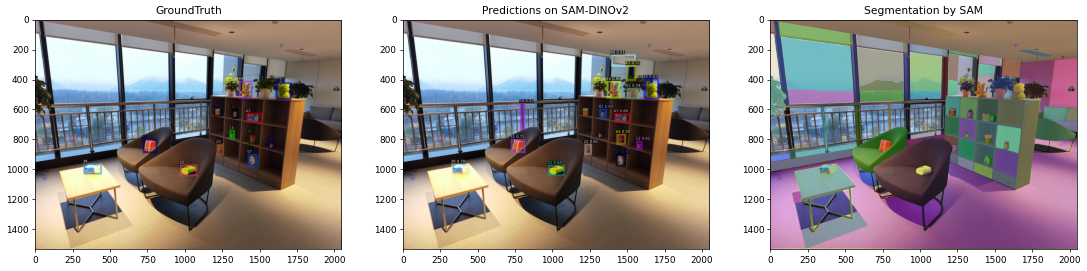

In [12]:
fig = plt.figure(figsize=(21, 7), dpi=64, facecolor='w', edgecolor='k')
ax = plt.subplot(131)
ax.set_title("GroundTruth")
plt.imshow(vis_gt.get_image()[:, :, :])
ax = plt.subplot(132)
ax.set_title("Predictions on SAM-DINOv2")
plt.imshow(vis_pred.get_image()[:, :, :])
ax = plt.subplot(133)
ax.set_title("Segmentation by SAM")
plt.imshow(scene_image)
show_anns(masks)
plt.show()